#### Author：马肖
#### E-Mail：maxiaoscut@aliyun.com
#### GitHub：https://github.com/Albertsr

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier  
from sklearn.datasets import load_breast_cancer 
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score  

### xgboost的fit方法提供了early_stopping的功能

https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier.fit

#### API：fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None, sample_weight_eval_set=None, callbacks=None)


- **参数eval_set：** 设置验证集
  - 一个[(X, y)]形式的列表，数据集(X, y)作为验证集;
  - eval_set包含n个数据对时，以最后一个数据对validation_n的性能作为验证标准


- **参数eval_metric：**设置验证指标
  - 模型的评判指标，常见的有"rmse"、"mae"、"logloss"、"error"、"merror"、"mlogloss"、"auc"等
  - 详情见https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
  - 当设置多个m评判标准时，例如eval_metric=["auc","logloss"]，则以后一个"logloss"为准


- **参数early_stopping_rounds**
  - 若early_stopping_rounds=n,意味着模型性能指标在n轮迭代之内没有改善时,将会early_stop
  - early_stop发生后，模型会生成3个额外的属性：best_score、best_iteration、best_ntree_limit，
  - best_ntree_limit总是等于best_iteration + 1


- **参数verbose：**布尔型参数，决定是否返回模型在验证集上的性能表现

In [2]:
X, y = load_breast_cancer(return_X_y=True)  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2018) 
model = XGBClassifier(n_estimators=350, learning_rate=0.25, reg_lambda=1.05, random_state=2018)
eval_set = [(X_train, y_train), (X_test, y_test)]  
eval_metric = ["auc", "logloss"]
model.fit(X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, early_stopping_rounds=25, verbose=False)  
model_best_trees = XGBClassifier(n_estimators=model.best_ntree_limit, random_state=2018)
description = "Best_iteration: {:} \nBest_trees: {:} \nBest_score: {:.3f}" 
print(description.format(model.best_iteration, model.best_ntree_limit, model.best_score))

Best_iteration: 47 
Best_trees: 48 
Best_score: 0.112


In [3]:
y_pred = model.predict(X_test)  
accuracy = accuracy_score(y_test, y_pred)  
print("Accuracy_original: {:.3f}".format(accuracy)) 

model_best_trees.fit(X_train, y_train)
y_pred_revised = model_best_trees.predict(X_test)  
accuracy = accuracy_score(y_test, y_pred_revised)  
print("Accuracy_revised: {:.3f}".format(accuracy)) 

Accuracy_original: 0.951
Accuracy_revised: 0.958


### model.evals_result()以字典形式存储了模型训练过程中所有验证集上对应的各个性能指标的数值

In [4]:
evals_result = model.evals_result() 
assert isinstance(evals_result, dict), 'evals_result为字典格式'

### 单个性能指标的数值以列表形式存储，且列表长度等于验证次数，可以设置verbose=True来验证

In [5]:
valid1_logloss = evals_result['validation_1']['logloss']
assert isinstance(valid1_logloss, list), 'valid1_logloss为列表格式'
print('验证次数：{:}'.format(len(valid1_logloss)))

验证次数：72


In [6]:
train_auc = evals_result['validation_0']['auc']
train_logloss = evals_result['validation_0']['logloss']

test_auc = evals_result['validation_1']['auc']
test_logloss = evals_result['validation_1']['logloss']

evals_dict = {'Train_auc':train_auc, 'Test_auc':test_auc, 'Train_Logloss':train_logloss, 'Test_Logloss':test_logloss}
metrics_result = pd.DataFrame(evals_dict)
metrics_result.head()

,Train_auc,Test_auc,Train_Logloss,Test_Logloss
0,0.983374,0.949854,0.500370,0.517805
1,0.985724,0.948710,0.378675,0.413641
2,0.992065,0.978985,0.294743,0.340636
3,0.992266,0.977944,0.237454,0.292789
4,0.995513,0.985539,0.193040,0.253936


#### 将模型在[(X_train, y_train), (X_test, y_test)]上的性能表现随着迭代轮数的趋势可视化  

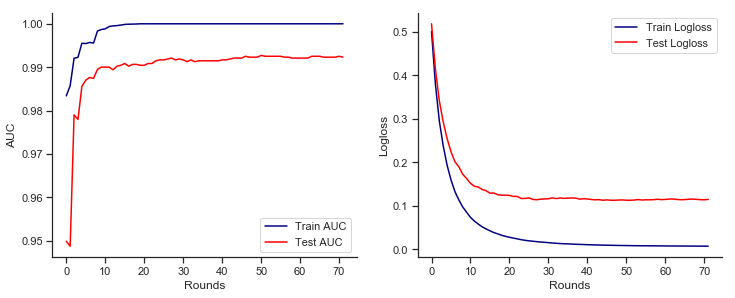

In [7]:
sns.set(font_scale=1.0, style='ticks', palette='summer') 
f, axes = plt.subplots(1, 2, figsize=(12, 4.5))

x = metrics_result.index
[y1, y2, y3, y4] = [metrics_result[i] for i in metrics_result.columns]

sns.lineplot(x, y1, ax=axes[0], color='navy', linestyle='--', label='Train AUC') 
sns.lineplot(x, y2, ax=axes[0], color="r", label='Test AUC')
sns.lineplot(x, y3, ax=axes[1], color='navy', label='Train Logloss')
sns.lineplot(x, y4, ax=axes[1], color="r", label='Test Logloss')

# 构建start=0, stop=tick_end, step=10的等差数列，作为x轴的坐标
tick_end = metrics_result.shape[0]
ticks = np.arange(0, tick_end, 10)

# 设置图像的轴标签
for i in [0, 1]: 
    if i == 0:
        axes[i].set_ylabel('AUC',fontsize=12)
        axes[i].set_xlabel('Rounds', fontsize=12)
    else:
        axes[i].set_ylabel('Logloss', fontsize=12)
        axes[i].set_xlabel('Rounds', fontsize=12)
    
    axes[i].set_xticks(ticks)
    sns.despine()